Alamouti STBC
=============

This notebook illustrates the simulation of an Alamouti MIMO scheme transmission through a flat fading rayleight channel.

We simulate the Alamouti STBC with a 16-QAM modulation, as well as BPSK modulation with 1 and two receive antennas.

**Note: This notebook uses the parallel capabilities of IPython. Thus you need to start the engines in the cluster pannel before running the code here.**

Initializations
---------------

First we create a IPython parallel client so that we can communicate with the engines.

In [44]:
%matplotlib inline
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [1]:
from IPython.parallel import Client
cl = Client()
cl.clear()  # Erases the workspace of the engines.
bview = cl.load_balanced_view()  # Create a load balanced view that we will use later.

Then we initialize the pylab inline in each engine.
Note that we use the **%px** IPython cell magic to run the code in the cell for each engine.

In [2]:
%%px
%pylab inline
from IPython.display import clear_output

[stdout:0] Populating the interactive namespace from numpy and matplotlib
[stdout:1] Populating the interactive namespace from numpy and matplotlib
[stdout:2] Populating the interactive namespace from numpy and matplotlib
[stdout:3] Populating the interactive namespace from numpy and matplotlib
[stdout:4] Populating the interactive namespace from numpy and matplotlib
[stdout:5] Populating the interactive namespace from numpy and matplotlib
[stdout:6] Populating the interactive namespace from numpy and matplotlib
[stdout:7] Populating the interactive namespace from numpy and matplotlib


Similarly, we set the Python path and import some libraries at each engine.

In [36]:
%%px
# xxxxxxxxxx Add the parent folder to the python path. xxxxxxxxxxxxxxxxxxxx
import sys
import os
sys.path.append('../')
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

import numpy as np

Because there is already an Alamouti simulator implemented in the "apps" folder of PyPhysim, we simple import it here and set the desired simulation parameters.

In [4]:
%%px
from pyphysim.comm.modulators import BPSK, QAM
from apps.simulate_mimo import AlamoutiSimulationRunner

## Simulation of Alamouti with 16-QAM

First we create the SimulationRunner objects at each engine and set the parameters which are common to all engines. 

Note that the actual simulator is already implemented as an application in PyPhysim and we are only setting the parameters here.

In [5]:
%%px
sim = AlamoutiSimulationRunner("mimo_alamouti_config_file.txt")
sim.NSymbs = 300
sim.rep_max = 10000
sim.params.add('SNR', np.linspace(0, 25, 11))
#sim.modulator = QAM(16)
#sim.Nr=1
sim.update_progress_function_style = None
# max_bit_errors is used in the _keep_going method to stop the
# simulation earlier if possible. We stop the simulation if the
# accumulated number of bit errors becomes greater then 0.1% of the
# total number of simulated bits
sim.max_bit_errors = sim.rep_max * sim.NSymbs * 0.001
sim.clear()

We still need to set the **self.modulator** parameter with the desired modulator as well as the **self.Nr** parameter with the desired number of receive antennas. These values will differ at each engine.
After that, we can call the simulate method to perform the actual simulation.

Lets create a function that sets the modulator and number of receive antennas in the SimulationRunner object, calls its simulate method and then return the object. This is so that we can use the **map** method of a load_balanced_view.

In [6]:
# Note that we run this on the local instance, instead of in the remote engines. That is, we do not use the %%px cell magic here.
def set_params_and_simulate(params_list):
    """params_list must be a list with two elements, the modulator object, and the number of receive antennas."""
    modulator, Nr = params_list
    sim.modulator = modulator
    sim.Nr = Nr
    
    sim.simulate()
    return sim

Now lets create all the combination of modulator and number of receive antennas.

In [7]:
# xxxxxxxxxx Add the parent folder to the python path. xxxxxxxxxxxxxxxxxxxx
import sys
import os
sys.path.append('../')
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
from pyphysim.comm.modulators import BPSK, QAM
combinations = [[QAM(16), 1], [QAM(16), 2], [BPSK(), 1], [BPSK(), 2]]

Now we can call the map_sync method of the balanced view to perform the simulations in parallel.

In [8]:
from pyphysim.util.misc import pretty_time
from time import time, sleep
tic = time()
results = bview.map_sync(set_params_and_simulate, combinations)
toc = time()

print "Total elapsed time: {0}".format(pretty_time(toc-tic))

Total elapsed time: 1m:53s


Since we used the map_sync method, then **results** will be a list containing the SimulationRunner objects (since set_params_and_simulate returns the SimulationRunner object)

Therefore, lets get the individual SimulationRunner objects.

In [9]:
sim1, sim2, sim3, sim4 = results
print "Elapsed time sim1: {0}".format(sim1.elapsed_time)
print "Elapsed time sim2: {0}".format(sim2.elapsed_time)
print "Elapsed time sim3: {0}".format(sim3.elapsed_time)
print "Elapsed time sim4: {0}".format(sim4.elapsed_time)

Elapsed time sim1: 1m:53s
Elapsed time sim2: 1m:51s
Elapsed time sim3: 1m:29s
Elapsed time sim4: 1m:35s


## Plot the results

With the SimulationRunner objects we can now get the results for each configuration.

Lets get the results for 16-QAM modulation

In [31]:
def get_data_to_be_plotted(sim):
    SNR = sim.params['SNR']
    ber = np.array([r.get_result() for r in sim.results['ber']])
    ser = np.array([r.get_result() for r in sim.results['ser']])
    return SNR, ber, ser

SNR, ber1, ser1 = get_data_to_be_plotted(sim1)
SNR, ber2, ser2 = get_data_to_be_plotted(sim2)

and now the results for BPSK modulation

In [33]:
SNR, ber3, ser3 = get_data_to_be_plotted(sim3)
SNR, ber4, ser4 = get_data_to_be_plotted(sim4)

Now we have what we need to plot everything.

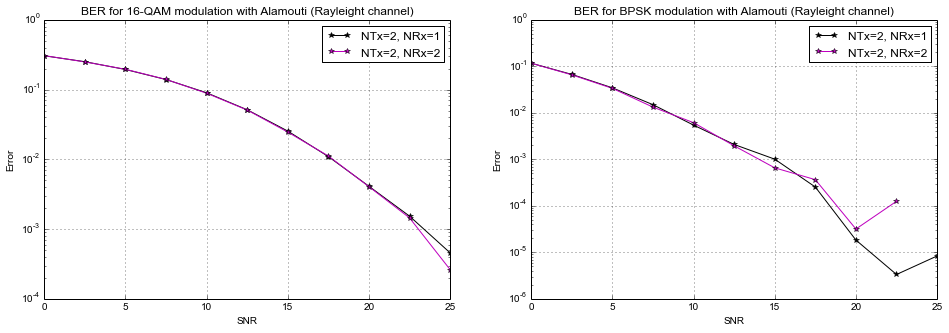

In [48]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(16,5))
ax1, ax2 = ax

# Plot the 16-QAM results
ax1.semilogy(SNR, ber1, '-k*', label='NTx=2, NRx=1')
ax1.semilogy(SNR, ber2, '-m*', label='NTx=2, NRx=2')
ax1.set_title('BER for {0} modulation with Alamouti (Rayleight channel)'.format(sim1.modulator.name))
ax1.set_xlabel('SNR')
ax1.set_ylabel('Error')
ax1.legend()
ax1.grid()
# Plot the BPSK results
ax2.semilogy(SNR, ber3, '-k*', label='NTx=2, NRx=1')
ax2.semilogy(SNR, ber4, '-m*', label='NTx=2, NRx=2')
ax2.set_title('BER for {0} modulation with Alamouti (Rayleight channel)'.format(sim3.modulator.name))
ax2.set_xlabel('SNR')
ax2.set_ylabel('Error')
ax2.legend()
ax2.grid()

plt.show()

--------------------------------

In [ ]:
#%qtconsole